# Task 2: Symbolic Regression

The purpose of this task is to use symbolic regression to find a mathematical expression that fits the data. There are three datasets provided with increasing difficulty. Before starting the challenge, we need to install the necessary libraries and visualise the data.

## 1. Install the necessary libraries

In [1]:
# Install the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

Here there is the use of all the functions necessary for PDE-FIND, that was the library that was used to solve the task. The functions are required to take derivatives, build the Theta matrix, and train the STRidge model.


### Differentiation Methods

- **TikhonovDiff**: Computes derivatives using Tikhonov regularization, minimizing the derivative's L2 norm with a penalty term.
- **FiniteDiff**: Computes higher-order derivatives using finite difference methods.
- **ConvSmoother**: Smooths noisy data using a Gaussian smoothing kernel.
- **PolyDiff**: Computes derivatives using polynomial fitting, robust to noisy data.
- **PolyDiffPoint**: Computes derivatives at a specific point using polynomial fitting.

### Functions Specific to PDE Identification (PDE-FIND)

- **build_Theta**: Constructs a matrix representing polynomials of all variables up to a specified degree, used for subsampling and derivative calculation.
- **build_linear_system**: Constructs a large linear system to find PDEs through regression, using specified methods for time and space derivatives.
- **print_pde**: Prints the identified PDE based on coefficients and descriptions.

### Sparse Regression Functions

- **TrainSTRidge**: Trains a predictor using Sequential Threshold Ridge Regression (STRidge) to find sparse approximations to the inverse of a matrix.
- **Lasso**: Solves Lasso regression using accelerated proximal gradient (FISTA).
- **ElasticNet**: Solves Elastic Net regression using accelerated proximal gradient (FISTA).
- **STRidge**: Sequential Threshold Ridge Regression (STRidge) algorithm for sparse approximation.

In [2]:
import numpy as np
from numpy import linalg as LA
import scipy.sparse as sparse
from scipy.sparse import csc_matrix
from scipy.sparse import dia_matrix
import itertools
import operator

"""
A few functions used in PDE-FIND

Samuel Rudy.  2016

"""


##################################################################################
##################################################################################
#
# Functions for taking derivatives.
# When in doubt / nice data ===> finite differences
#               \ noisy data ===> polynomials
#
##################################################################################
##################################################################################

def TikhonovDiff(f, dx, lam, d = 1):
    """
    Tikhonov differentiation.

    return argmin_g \|Ag-f\|_2^2 + lam*\|Dg\|_2^2
    where A is trapezoidal integration and D is finite differences for first dervative

    It looks like it will work well and does for the ODE case but
    tends to introduce too much bias to work well for PDEs.  If the data is noisy, try using
    polynomials instead.
    """

    # Initialize a few things
    n = len(f)
    f = np.matrix(f - f[0]).reshape((n,1))

    # Get a trapezoidal approximation to an integral
    A = np.zeros((n,n))
    for i in range(1, n):
        A[i,i] = dx/2
        A[i,0] = dx/2
        for j in range(1,i): A[i,j] = dx

    e = np.ones(n-1)
    D = sparse.diags([e, -e], [1, 0], shape=(n-1, n)).todense() / dx

    # Invert to find derivative
    g = np.squeeze(np.asarray(np.linalg.lstsq(A.T.dot(A) + lam*D.T.dot(D),A.T.dot(f),rcond=None)[0]))

    if d == 1: return g

    # If looking for a higher order derivative, this one should be smooth so now we can use finite differences
    else: return FiniteDiff(g, dx, d-1)

def FiniteDiff(u, dx, d):
    """
    Takes dth derivative data using 2nd order finite difference method (up to d=3)
    Works but with poor accuracy for d > 3

    Input:
    u = data to be differentiated
    dx = Grid spacing.  Assumes uniform spacing
    """

    n = u.size
    ux = np.zeros(n, dtype=np.complex64)

    if d == 1:
        for i in range(1,n-1):
            ux[i] = (u[i+1]-u[i-1]) / (2*dx)

        ux[0] = (-3.0/2*u[0] + 2*u[1] - u[2]/2) / dx
        ux[n-1] = (3.0/2*u[n-1] - 2*u[n-2] + u[n-3]/2) / dx
        return ux

    if d == 2:
        for i in range(1,n-1):
            ux[i] = (u[i+1]-2*u[i]+u[i-1]) / dx**2

        ux[0] = (2*u[0] - 5*u[1] + 4*u[2] - u[3]) / dx**2
        ux[n-1] = (2*u[n-1] - 5*u[n-2] + 4*u[n-3] - u[n-4]) / dx**2
        return ux

    if d == 3:
        for i in range(2,n-2):
            ux[i] = (u[i+2]/2-u[i+1]+u[i-1]-u[i-2]/2) / dx**3

        ux[0] = (-2.5*u[0]+9*u[1]-12*u[2]+7*u[3]-1.5*u[4]) / dx**3
        ux[1] = (-2.5*u[1]+9*u[2]-12*u[3]+7*u[4]-1.5*u[5]) / dx**3
        ux[n-1] = (2.5*u[n-1]-9*u[n-2]+12*u[n-3]-7*u[n-4]+1.5*u[n-5]) / dx**3
        ux[n-2] = (2.5*u[n-2]-9*u[n-3]+12*u[n-4]-7*u[n-5]+1.5*u[n-6]) / dx**3
        return ux

    if d > 3:
        return FiniteDiff(FiniteDiff(u,dx,3), dx, d-3)

def ConvSmoother(x, p, sigma):
    """
    Smoother for noisy data

    Inpute = x, p, sigma
    x = one dimensional series to be smoothed
    p = width of smoother
    sigma = standard deviation of gaussian smoothing kernel
    """

    n = len(x)
    y = np.zeros(n, dtype=np.complex64)
    g = np.exp(-np.power(np.linspace(-p,p,2*p),2)/(2.0*sigma**2))

    for i in range(n):
        a = max([i-p,0])
        b = min([i+p,n])
        c = max([0, p-i])
        d = min([2*p,p+n-i])
        y[i] = np.sum(np.multiply(x[a:b], g[c:d]))/np.sum(g[c:d])

    return y

def PolyDiff(u, x, deg = 3, diff = 1, width = 5):

    """
    u = values of some function
    x = x-coordinates where values are known
    deg = degree of polynomial to use
    diff = maximum order derivative we want
    width = width of window to fit to polynomial

    This throws out the data close to the edges since the polynomial derivative only works
    well when we're looking at the middle of the points fit.
    """

    u = u.flatten()
    x = x.flatten()

    n = len(x)
    du = np.zeros((n - 2*width,diff))

    # Take the derivatives in the center of the domain
    for j in range(width, n-width):

        # Note code originally used an even number of points here.
        # This is an oversight in the original code fixed in 2022.
        points = np.arange(j - width, j + width + 1)

        # Fit to a polynomial
        poly = np.polynomial.chebyshev.Chebyshev.fit(x[points],u[points],deg)

        # Take derivatives
        for d in range(1,diff+1):
            du[j-width, d-1] = poly.deriv(m=d)(x[j])

    return du

def PolyDiffPoint(u, x, deg = 3, diff = 1, index = None):

    """
    Same as above but now just looking at a single point

    u = values of some function
    x = x-coordinates where values are known
    deg = degree of polynomial to use
    diff = maximum order derivative we want
    """

    n = len(x)
    if index == None: index = (n-1)//2

    # Fit to a polynomial
    poly = np.polynomial.chebyshev.Chebyshev.fit(x,u,deg)

    # Take derivatives
    derivatives = []
    for d in range(1,diff+1):
        derivatives.append(poly.deriv(m=d)(x[index]))

    return derivatives

##################################################################################
##################################################################################
#
# Functions specific to PDE-FIND
#
##################################################################################
##################################################################################

def build_Theta(data, derivatives, derivatives_description, P, data_description = None):
    """
    builds a matrix with columns representing polynoimials up to degree P of all variables

    This is used when we subsample and take all the derivatives point by point or if there is an
    extra input (Q in the paper) to put in.

    input:
        data: column 0 is U, and columns 1:end are Q
        derivatives: a bunch of derivatives of U and maybe Q, should start with a column of ones
        derivatives_description: description of what derivatives have been passed in
        P: max power of polynomial function of U to be included in Theta

    returns:
        Theta = Theta(U,Q)
        descr = description of what all the columns in Theta are
    """

    n,d = data.shape
    m, d2 = derivatives.shape
    if n != m: raise Exception('dimension error')
    if data_description is not None:
        if len(data_description) != d: raise Exception('data descrption error')

    # Create a list of all polynomials in d variables up to degree P
    rhs_functions = {}
    f = lambda x, y : np.prod(np.power(list(x), list(y)))
    powers = []
    for p in range(1,P+1):
            size = d + p - 1
            for indices in itertools.combinations(range(size), d-1):
                starts = [0] + [index+1 for index in indices]
                stops = indices + (size,)
                powers.append(tuple(map(operator.sub, stops, starts)))
    for power in powers: rhs_functions[power] = [lambda x, y = power: f(x,y), power]

    # First column of Theta is just ones.
    Theta = np.ones((n,1), dtype=np.complex64)
    descr = ['']

    # Add the derivaitves onto Theta
    for D in range(1,derivatives.shape[1]):
        Theta = np.hstack([Theta, derivatives[:,D].reshape(n,1)])
        descr.append(derivatives_description[D])

    # Add on derivatives times polynomials
    for D in range(derivatives.shape[1]):
        for k in rhs_functions.keys():
            func = rhs_functions[k][0]
            new_column = np.zeros((n,1), dtype=np.complex64)
            for i in range(n):
                new_column[i] = func(data[i,:])*derivatives[i,D]
            Theta = np.hstack([Theta, new_column])
            if data_description is None: descr.append(str(rhs_functions[k][1]) + derivatives_description[D])
            else:
                function_description = ''
                for j in range(d):
                    if rhs_functions[k][1][j] != 0:
                        if rhs_functions[k][1][j] == 1:
                            function_description = function_description + data_description[j]
                        else:
                            function_description = function_description + data_description[j] + '^' + str(rhs_functions[k][1][j])
                descr.append(function_description + derivatives_description[D])

    return Theta, descr

def build_linear_system(u, dt, dx, D = 3, P = 3,time_diff = 'poly',space_diff = 'poly',lam_t = None,lam_x = None, width_x = None,width_t = None, deg_x = 5,deg_t = None,sigma = 2):
    """
    Constructs a large linear system to use in later regression for finding PDE.
    This function works when we are not subsampling the data or adding in any forcing.

    Input:
        Required:
            u = data to be fit to a pde
            dt = temporal grid spacing
            dx = spatial grid spacing
        Optional:
            D = max derivative to include in rhs (default = 3)
            P = max power of u to include in rhs (default = 3)
            time_diff = method for taking time derivative
                        options = 'poly', 'FD', 'FDconv','TV'
                        'poly' (default) = interpolation with polynomial
                        'FD' = standard finite differences
                        'FDconv' = finite differences with convolutional smoothing
                                   before and after along x-axis at each timestep
                        'Tik' = Tikhonov (takes very long time)
            space_diff = same as time_diff with added option, 'Fourier' = differentiation via FFT
            lam_t = penalization for L2 norm of second time derivative
                    only applies if time_diff = 'TV'
                    default = 1.0/(number of timesteps)
            lam_x = penalization for L2 norm of (n+1)st spatial derivative
                    default = 1.0/(number of gridpoints)
            width_x = number of points to use in polynomial interpolation for x derivatives
                      or width of convolutional smoother in x direction if using FDconv
            width_t = number of points to use in polynomial interpolation for t derivatives
            deg_x = degree of polynomial to differentiate x
            deg_t = degree of polynomial to differentiate t
            sigma = standard deviation of gaussian smoother
                    only applies if time_diff = 'FDconv'
                    default = 2
    Output:
        ut = column vector of length u.size
        R = matrix with ((D+1)*(P+1)) of column, each as large as ut
        rhs_description = description of what each column in R is
    """

    n, m = u.shape

    if width_x == None: width_x = n//10
    if width_t == None: width_t = m//10
    if deg_t == None: deg_t = deg_x

    # If we're using polynomials to take derviatives, then we toss the data around the edges.
    if time_diff == 'poly':
        m2 = m-2*width_t
        offset_t = width_t
    else:
        m2 = m
        offset_t = 0
    if space_diff == 'poly':
        n2 = n-2*width_x
        offset_x = width_x
    else:
        n2 = n
        offset_x = 0

    if lam_t == None: lam_t = 1.0/m
    if lam_x == None: lam_x = 1.0/n

    ########################
    # First take the time derivaitve for the left hand side of the equation
    ########################
    ut = np.zeros((n2,m2), dtype=np.complex64)

    if time_diff == 'FDconv':
        Usmooth = np.zeros((n,m), dtype=np.complex64)
        # Smooth across x cross-sections
        for j in range(m):
            Usmooth[:,j] = ConvSmoother(u[:,j],width_t,sigma)
        # Now take finite differences
        for i in range(n2):
            ut[i,:] = FiniteDiff(Usmooth[i + offset_x,:],dt,1)

    elif time_diff == 'poly':
        T= np.linspace(0,(m-1)*dt,m)
        for i in range(n2):
            ut[i,:] = PolyDiff(u[i+offset_x,:],T,diff=1,width=width_t,deg=deg_t)[:,0]

    elif time_diff == 'Tik':
        for i in range(n2):
            ut[i,:] = TikhonovDiff(u[i + offset_x,:], dt, lam_t)

    else:
        for i in range(n2):
            ut[i,:] = FiniteDiff(u[i + offset_x,:],dt,1)

    ut = np.reshape(ut, (n2*m2,1), order='F')

    ########################
    # Now form the rhs one column at a time, and record what each one is
    ########################

    u2 = u[offset_x:n-offset_x,offset_t:m-offset_t]
    Theta = np.zeros((n2*m2, (D+1)*(P+1)), dtype=np.complex64)
    ux = np.zeros((n2,m2), dtype=np.complex64)
    rhs_description = ['' for i in range((D+1)*(P+1))]

    if space_diff == 'poly':
        Du = {}
        for i in range(m2):
            Du[i] = PolyDiff(u[:,i+offset_t],np.linspace(0,(n-1)*dx,n),diff=D,width=width_x,deg=deg_x)
    if space_diff == 'Fourier': ik = 1j*np.fft.fftfreq(n)*n

    for d in range(D+1):

        if d > 0:
            for i in range(m2):
                if space_diff == 'Tik': ux[:,i] = TikhonovDiff(u[:,i+offset_t], dx, lam_x, d=d)
                elif space_diff == 'FDconv':
                    Usmooth = ConvSmoother(u[:,i+offset_t],width_x,sigma)
                    ux[:,i] = FiniteDiff(Usmooth,dx,d)
                elif space_diff == 'FD': ux[:,i] = FiniteDiff(u[:,i+offset_t],dx,d)
                elif space_diff == 'poly': ux[:,i] = Du[i][:,d-1]
                elif space_diff == 'Fourier': ux[:,i] = np.fft.ifft(ik**d*np.fft.fft(ux[:,i]))
        else: ux = np.ones((n2,m2), dtype=np.complex64)

        for p in range(P+1):
            Theta[:, d*(P+1)+p] = np.reshape(np.multiply(ux, np.power(u2,p)), (n2*m2), order='F')

            if p == 1: rhs_description[d*(P+1)+p] = rhs_description[d*(P+1)+p]+'u'
            elif p>1: rhs_description[d*(P+1)+p] = rhs_description[d*(P+1)+p]+'u^' + str(p)
            if d > 0: rhs_description[d*(P+1)+p] = rhs_description[d*(P+1)+p]+\
                                                   'u_{' + ''.join(['x' for _ in range(d)]) + '}'

    return ut, Theta, rhs_description

def print_pde(w, rhs_description, ut = 'u_t'):
    pde = ut + ' = '
    first = True
    for i in range(len(w)):
        if w[i] != 0:
            if not first:
                pde = pde + ' + '
            pde = pde + "(%05f %+05fi)" % (w[i].real, w[i].imag) + rhs_description[i] + "\n   "
            first = False
    print(pde)

##################################################################################
##################################################################################
#
# Functions for sparse regression.
#
##################################################################################
##################################################################################

def TrainSTRidge(R, Ut, lam, d_tol, maxit = 25, STR_iters = 10, l0_penalty = None, normalize = 2, split = 0.8, print_best_tol = False):
    """
    This function trains a predictor using STRidge.

    It runs over different values of tolerance and trains predictors on a training set, then evaluates them
    using a loss function on a holdout set.

    Please note published article has typo.  Loss function used here for model selection evaluates fidelity using 2-norm,
    not squared 2-norm.
    """

    # Split data into 80% training and 20% test, then search for the best tolderance.
    np.random.seed(0) # for consistancy
    n,_ = R.shape
    train = np.random.choice(n, int(n*split), replace = False)
    test = [i for i in np.arange(n) if i not in train]
    TrainR = R[train,:]
    TestR = R[test,:]
    TrainY = Ut[train,:]
    TestY = Ut[test,:]
    D = TrainR.shape[1]

    # Set up the initial tolerance and l0 penalty
    d_tol = float(d_tol)
    tol = d_tol
    if l0_penalty == None: l0_penalty = 0.001*np.linalg.cond(R)

    # Get the standard least squares estimator
    w = np.zeros((D,1))
    w_best = np.linalg.lstsq(TrainR, TrainY,rcond=None)[0]
    err_best = np.linalg.norm(TestY - TestR.dot(w_best), 2) + l0_penalty*np.count_nonzero(w_best)
    tol_best = 0

    # Now increase tolerance until test performance decreases
    for iter in range(maxit):

        # Get a set of coefficients and error
        w = STRidge(TrainR,TrainY,lam,STR_iters,tol,normalize = normalize)
        err = np.linalg.norm(TestY - TestR.dot(w), 2) + l0_penalty*np.count_nonzero(w)

        # Has the accuracy improved?
        if err <= err_best:
            err_best = err
            w_best = w
            tol_best = tol
            tol = tol + d_tol

        else:
            tol = max([0,tol - 2*d_tol])
            d_tol  = 2*d_tol / (maxit - iter)
            tol = tol + d_tol

    if print_best_tol: print("Optimal tolerance:", tol_best)

    return w_best

def Lasso(X0, Y, lam, w = np.array([0]), maxit = 100, normalize = 2):
    """
    Uses accelerated proximal gradient (FISTA) to solve Lasso
    argmin (1/2)*||Xw-Y||_2^2 + lam||w||_1
    """

    # Obtain size of X
    n,d = X0.shape
    X = np.zeros((n,d), dtype=np.complex64)
    Y = Y.reshape(n,1)

    # Create w if none is given
    if w.size != d:
        w = np.zeros((d,1), dtype=np.complex64)
    w_old = np.zeros((d,1), dtype=np.complex64)

    # Initialize a few other parameters
    converge = 0
    objective = np.zeros((maxit,1))

    # First normalize data
    if normalize != 0:
        Mreg = np.zeros((d,1))
        for i in range(0,d):
            Mreg[i] = 1.0/(np.linalg.norm(X0[:,i],normalize))
            X[:,i] = Mreg[i]*X0[:,i]
    else: X = X0

    # Lipschitz constant of gradient of smooth part of loss function
    L = np.linalg.norm(X.T.dot(X),2)

    # Now loop until converged or max iterations
    for iters in range(0, maxit):

        # Update w
        z = w + iters/float(iters+1)*(w - w_old)
        w_old = w
        z = z - X.T.dot(X.dot(z)-Y)/L
        for j in range(d): w[j] = np.multiply(np.sign(z[j]), np.max([abs(z[j])-lam/L,0]))

        # Could put in some sort of break condition based on convergence here.

    # Now that we have the sparsity pattern, used least squares.
    biginds = np.where(w != 0)[0]
    if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],Y,rcond=None)[0]

    # Finally, reverse the regularization so as to be able to use with raw data
    if normalize != 0: return np.multiply(Mreg,w)
    else: return w

def ElasticNet(X0, Y, lam1, lam2, w = np.array([0]), maxit = 100, normalize = 2):
    """
    Uses accelerated proximal gradient (FISTA) to solve elastic net
    argmin (1/2)*||Xw-Y||_2^2 + lam_1||w||_1 + (1/2)*lam_2||w||_2^2
    """

    # Obtain size of X
    n,d = X0.shape
    X = np.zeros((n,d), dtype=np.complex64)
    Y = Y.reshape(n,1)

    # Create w if none is given
    if w.size != d:
        w = np.zeros((d,1), dtype=np.complex64)
    w_old = np.zeros((d,1), dtype=np.complex64)

    # Initialize a few other parameters
    converge = 0
    objective = np.zeros((maxit,1))

    # First normalize data
    if normalize != 0:
        Mreg = np.zeros((d,1))
        for i in range(0,d):
            Mreg[i] = 1.0/(np.linalg.norm(X0[:,i],normalize))
            X[:,i] = Mreg[i]*X0[:,i]
    else: X = X0

    # Lipschitz constant of gradient of smooth part of loss function
    L = np.linalg.norm(X.T.dot(X),2) + lam2

    # Now loop until converged or max iterations
    for iters in range(0, maxit):

        # Update w
        z = w + iters/float(iters+1)*(w - w_old)
        w_old = w
        z = z - (lam2*z + X.T.dot(X.dot(z)-Y))/L
        for j in range(d): w[j] = np.multiply(np.sign(z[j]), np.max([abs(z[j])-lam1/L,0]))

        # Could put in some sort of break condition based on convergence here.

    # Now that we have the sparsity pattern, used least squares.
    biginds = np.where(w != 0)[0]
    if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],Y,rcond=None)[0]

    # Finally, reverse the regularization so as to be able to use with raw data
    if normalize != 0: return np.multiply(Mreg,w)
    else: return w

def STRidge(X0, y, lam, maxit, tol, normalize = 2, print_results = False):
    """
    Sequential Threshold Ridge Regression algorithm for finding (hopefully) sparse
    approximation to X^{-1}y.  The idea is that this may do better with correlated observables.

    This assumes y is only one column
    """

    n,d = X0.shape
    X = np.zeros((n,d), dtype=np.complex64)
    # First normalize data
    if normalize != 0:
        Mreg = np.zeros((d,1))
        for i in range(0,d):
            Mreg[i] = 1.0/(np.linalg.norm(X0[:,i],normalize))
            X[:,i] = Mreg[i]*X0[:,i]
    else: X = X0

    # Get the standard ridge esitmate
    if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y),rcond=None)[0]
    else: w = np.linalg.lstsq(X,y,rcond=None)[0]
    num_relevant = d
    biginds = np.where( abs(w) > tol)[0]

    # Threshold and continue
    for j in range(maxit):

        # Figure out which items to cut out
        smallinds = np.where( abs(w) < tol)[0]
        new_biginds = [i for i in range(d) if i not in smallinds]

        # If nothing changes then stop
        if num_relevant == len(new_biginds): break
        else: num_relevant = len(new_biginds)

        # Also make sure we didn't just lose all the coefficients
        if len(new_biginds) == 0:
            if j == 0:
                #if print_results: print "Tolerance too high - all coefficients set below tolerance"
                return w
            else: break
        biginds = new_biginds

        # Otherwise get a new guess
        w[smallinds] = 0
        if lam != 0: w[biginds] = np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + lam*np.eye(len(biginds)),X[:, biginds].T.dot(y),rcond=None)[0]
        else: w[biginds] = np.linalg.lstsq(X[:, biginds],y,rcond=None)[0]

    # Now that we have the sparsity pattern, use standard least squares to get w
    if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],y,rcond=None)[0]

    if normalize != 0: return np.multiply(Mreg,w)
    else: return w

def FoBaGreedy(X, y, epsilon = 0.1, maxit_f = 100, maxit_b = 5, backwards_freq = 5, relearn_f=True, relearn_b=True):
    """
    Forward-Backward greedy algorithm for sparse regression.
    See Zhang, Tom. 'Adaptive Forward-Backward Greedy Algorithm for Sparse Learning with Linear Models', NIPS, 2008

    The original version of this code that was uploaded github was contained errors.  This version has been corrected and
    also includes an variation of FoBa used in Thaler et al. 'Sparse identification of truncation errors,' JCP, 2019,where
    we have additionally used relearning on the backwards step.  This later implementation (currently set as the default
    with relearn_f=relearn_b=True) relearns non-zero terms of w, rather than only fitting the residual, as was done in Zhang.
    It is slower, more robust, but still in some cases underperforms STRidge.
    """

    n,d = X.shape
    F = {}
    F[0] = set()
    w = {}
    w[0] = np.zeros((d,1))
    k = 0
    delta = {}

    for forward_iter in range(maxit_f):

        k = k+1

        # forward step
        zero_coeffs = np.where(w[k-1] == 0)[0]
        if len(zero_coeffs)==0: return w[k-1]

        err_after_addition = []
        residual = y - X.dot(w[k-1])
        for i in zero_coeffs:

            if relearn_f:
                F_trial = F[k-1].union({i})
                w_added = np.zeros((d,1))
                w_added[list(F_trial)] = np.linalg.lstsq(X[:, list(F_trial)], y, rcond=None)[0]

            else:
                # Per figure 3 line 8 in paper, do not retrain old variables.
                # Only look for optimal alpha, which is solving for new w iff X is unitary
                alpha = X[:,i].T.dot(residual)/np.linalg.norm(X[:,i])**2
                w_added = np.copy(w[k-1])
                w_added[i] = alpha

            err_after_addition.append(np.linalg.norm(X.dot(w_added)-y))
        i = zero_coeffs[np.argmin(err_after_addition)]

        F[k] = F[k-1].union({i})
        w[k] = np.zeros((d,1), dtype=np.complex64)
        w[k][list(F[k])] = np.linalg.lstsq(X[:, list(F[k])], y,rcond=None)[0]

        # check for break condition
        delta[k] = np.linalg.norm(X.dot(w[k-1]) - y) - np.linalg.norm(X.dot(w[k]) - y)
        if delta[k] < epsilon: return w[k-1]

        # backward step, do once every few forward steps
        if forward_iter % backwards_freq == 0 and forward_iter > 0:

            for backward_iter in range(maxit_b):

                non_zeros = np.where(w[k] != 0)[0]
                err_after_simplification = []
                for j in non_zeros:

                    if relearn_b:
                        F_trial = F[k].difference({j})
                        w_simple = np.zeros((d,1))
                        w_simple[list(F_trial)] = np.linalg.lstsq(X[:, list(F_trial)], y, rcond=None)[0]

                    else:
                        w_simple = np.copy(w[k])
                        w_simple[j] = 0

                    err_after_simplification.append(np.linalg.norm(X.dot(w_simple) - y))
                j = np.argmin(err_after_simplification)
                w_simple = np.copy(w[k])
                w_simple[non_zeros[j]] = 0

                # check for break condition on backward step
                delta_p = err_after_simplification[j] - np.linalg.norm(X.dot(w[k]) - y)
                if delta_p > 0.5*delta[k]: break

                k = k-1;
                F[k] = F[k+1].difference({j})
                w[k] = np.zeros((d,1))
                w[k][list(F[k])] = np.linalg.lstsq(X[:, list(F[k])], y,rcond=None)[0]

    return w[k]

## 2. Load and visualise the data

The first step is to load the data and visualise it. The data is stored in a .npz file, which is a zipped archive of numpy files. The data is stored in a dictionary-like format. The keys in the dictionary are the names of the variables, and the values are the data arrays. The data consists of the input, output, and time values. The data is visualised in 2D and 3D plots.

In [3]:
data_p1 = np.load('1.npz')
data_p2 = np.load('2.npz')
data_p3 = np.load('3.npz')

### 2.1. Dataset 1

Here is possible to see the components of the dataset. The data is stored in a dictionary-like format. The keys in the dictionary are the names of the variables, and the values are the data arrays. The data consists of the input, output, and time values.

In [4]:
data_p1.files

['u', 'x', 't']

there are three values in the dataset 1. In this case, x is the input, and u the output. The system is also time dependent as we can see from the t value. Let's visualise the data.

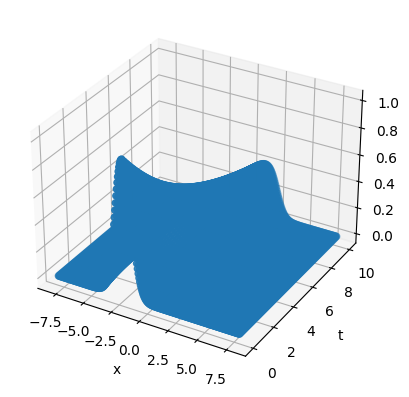

In [5]:
# Visualise the data with a 3D plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_p1['x'], data_p1['t'], data_p1['u'])
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.show()

The data is visualised in a 3D plot. The x-axis represents the input, the y-axis the time, and the z-axis the output. The data is not linear.

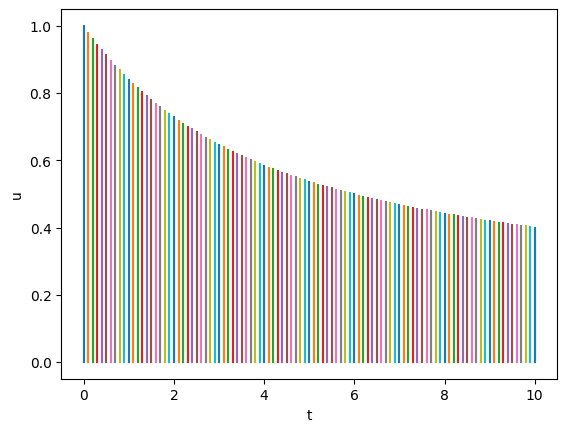

In [6]:
# Visualise the data with a 2D plot with a constant value of x
plt.plot(data_p1['t'], data_p1['u'])
plt.xlabel('t')
plt.ylabel('u')
plt.show()


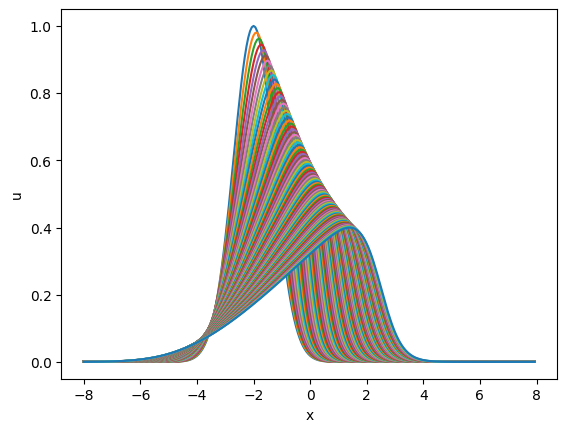

In [7]:
# Visualise the data with a 2D plot with a constant value of t
plt.plot(data_p1['x'], data_p1['u'])
plt.xlabel('x')
plt.ylabel('u')
plt.show()


Assumptions: Burger's Equation.

### 2.2. Dataset 2

In [8]:
data_p2.files

['u', 'x', 't']

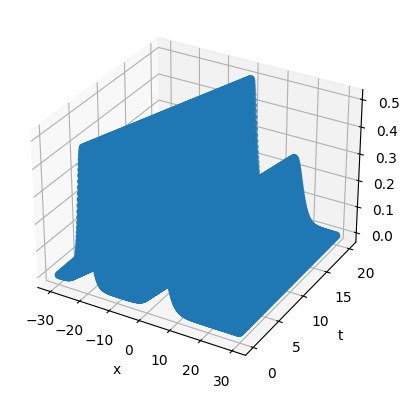

In [9]:
# Visualise the data with a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_p2['x'], data_p2['t'], data_p2['u'])
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.show()


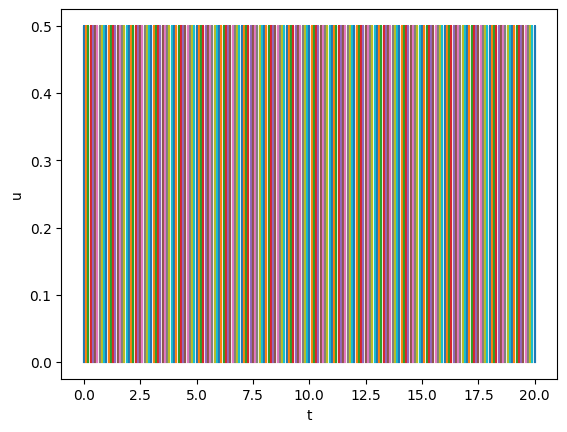

In [10]:
# Visualise the data with a 2D plot with a constant value of x
plt.plot(data_p2['t'], data_p2['u'])
plt.xlabel('t')
plt.ylabel('u')
plt.show()


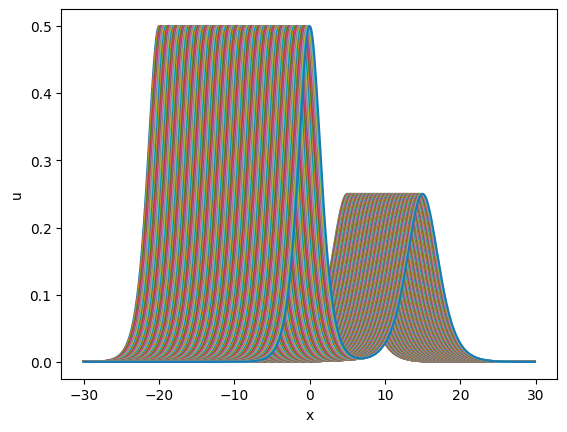

In [11]:
# Visualise the data with a 2D plot with a constant value of t
plt.plot(data_p2['x'], data_p2['u'])
plt.xlabel('x')
plt.ylabel('u')
plt.show()


Assumption: KdV equation

### 2.3. Dataset 3

In [12]:
data_p3.files

['u', 'v', 'x', 'y', 't']

in this case there are 5 values given that the solution is a vector field with two components:
- u(x, y,t)
- v(x, y,t)

It's possible to visualise them independently or together. Let's start by visualising them independently.

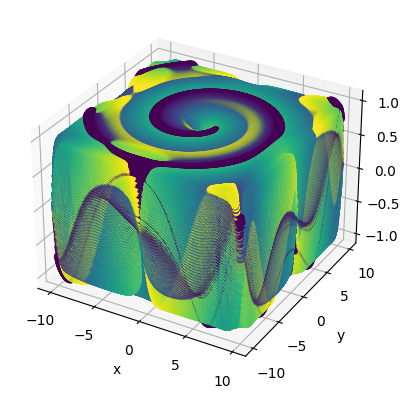

In [13]:
# Visualise the data with a 4D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_p3['x'], data_p3['y'], data_p3['u'], c=data_p3['t'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
plt.show()

for a more detailed visualisation, it may be helpful to fix some moments in time and visualise the data in 3D to understand how the system would evolve

In [14]:
a = data_p3['x'][data_p3['t'] == 4]
b = data_p3['y'][data_p3['t'] == 4]
c = data_p3['u'][data_p3['t'] == 4]

In [15]:
time_range = [0,1,2,3,4,5,6,7,8,9,10]

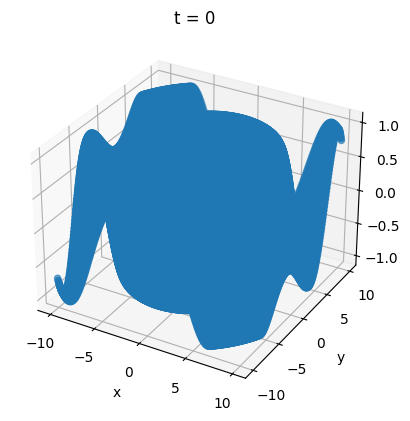

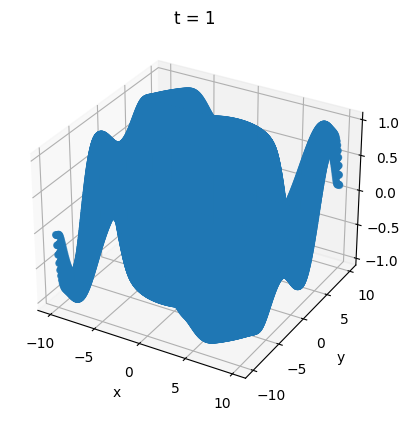

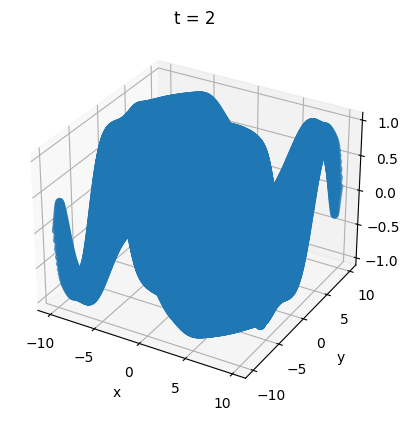

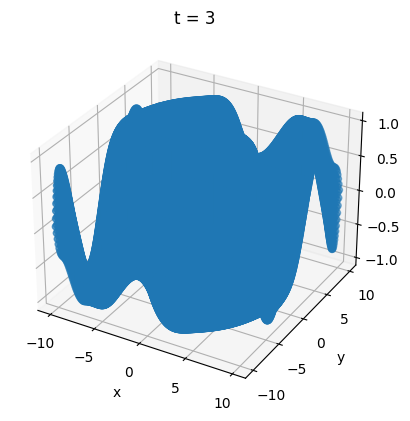

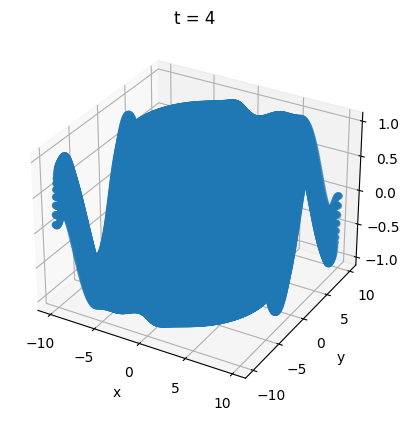

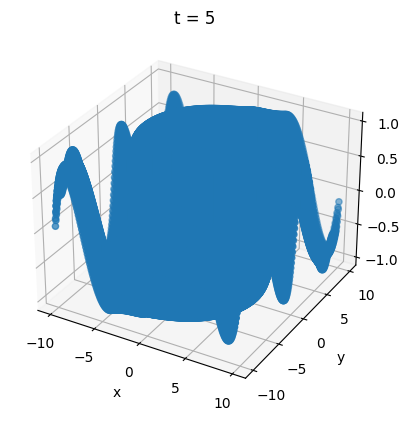

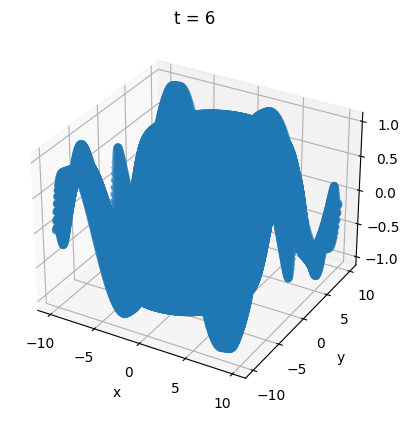

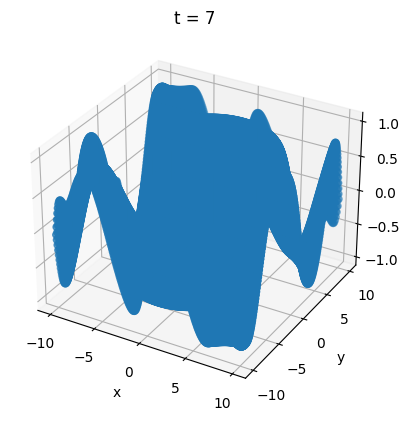

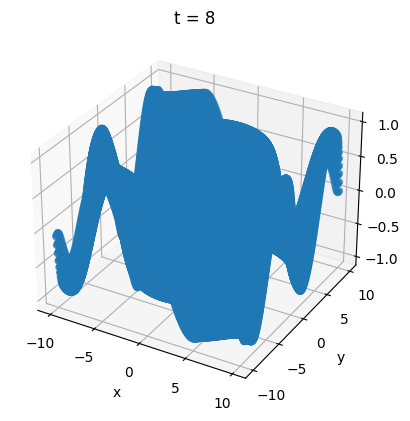

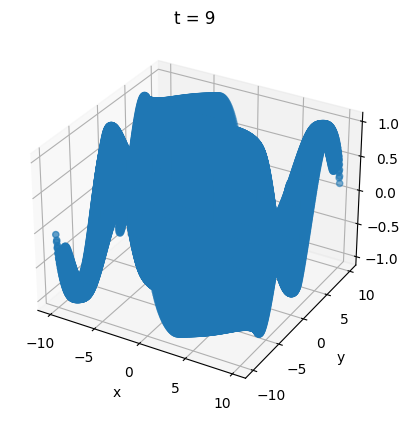

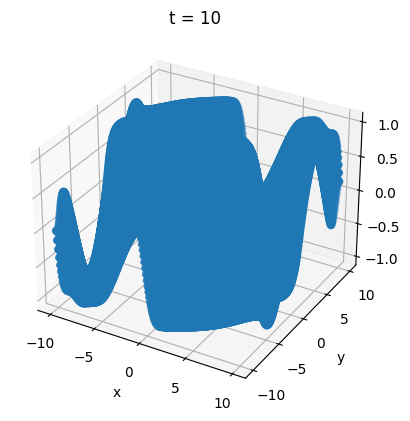

In [16]:
for i in time_range:
    a = data_p3['x'][data_p3['t'] == i]
    b = data_p3['y'][data_p3['t'] == i]
    c = data_p3['u'][data_p3['t'] == i]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(a, b, c)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    plt.title('t = ' + str(i))
    plt.show()

Here is possible to see a general evolution of the system over time. The same can be done for the v component.

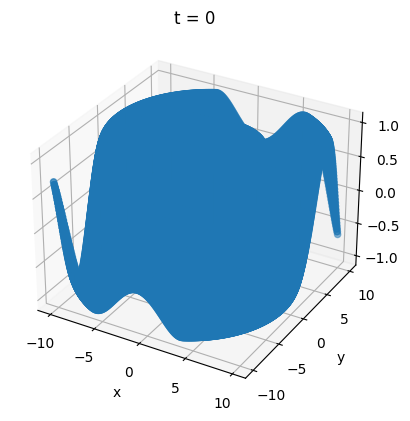

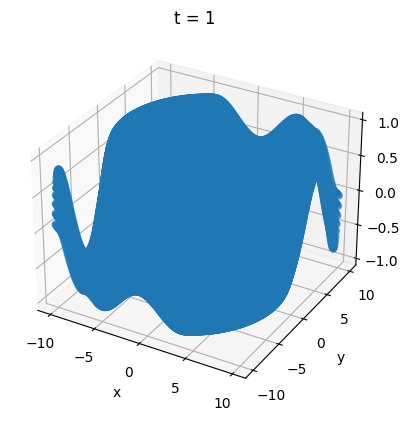

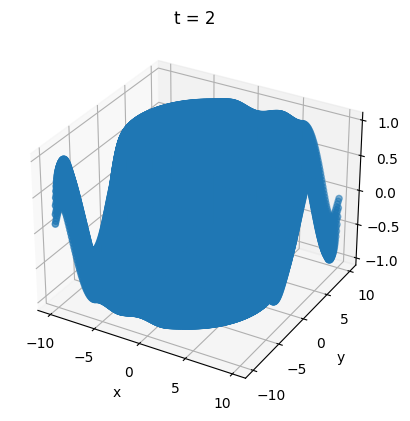

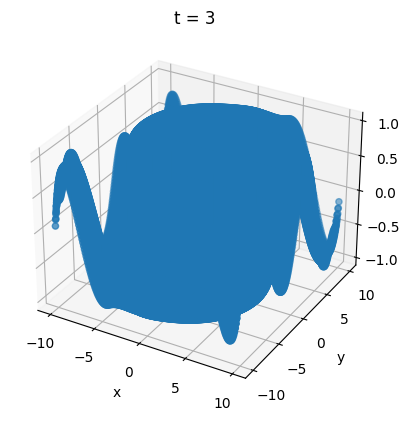

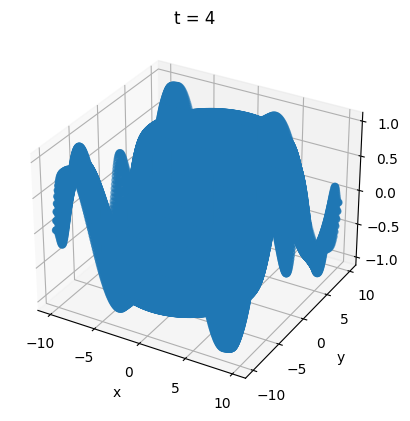

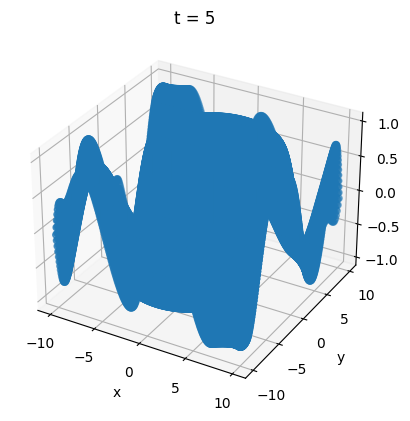

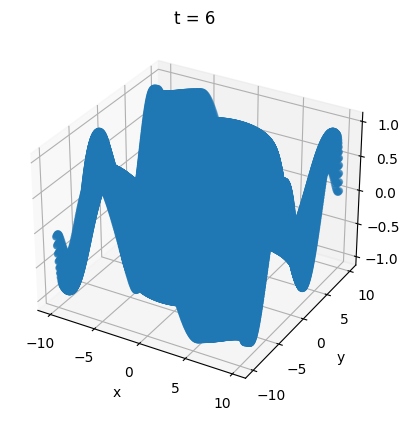

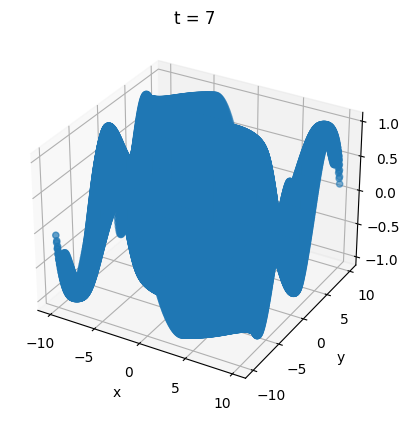

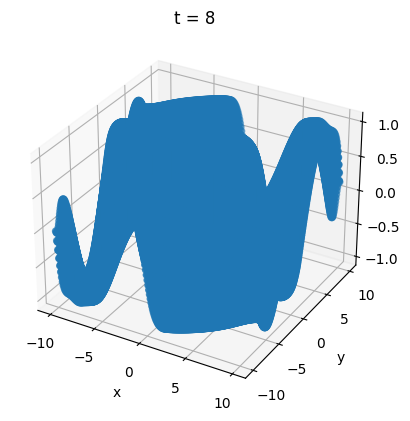

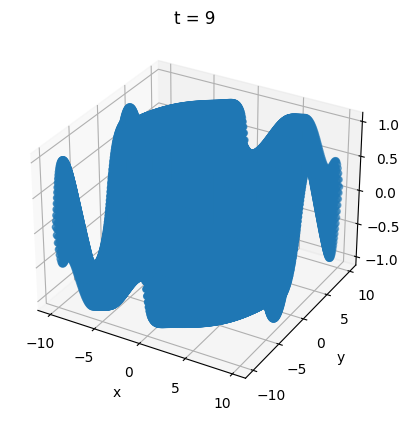

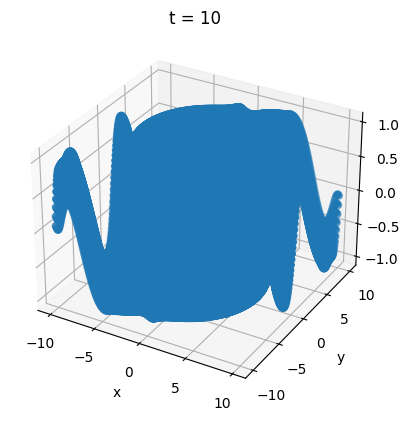

In [17]:
for i in time_range:
    a = data_p3['x'][data_p3['t'] == i]
    b = data_p3['y'][data_p3['t'] == i]
    c = data_p3['v'][data_p3['t'] == i]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(a, b, c)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('v')
    plt.title('t = ' + str(i))
    plt.show()

Assumption: Reaction-Diffusion Equation

## 3 Problem 1 - Burgers equation

A similar tutorial to solve the first exercise can be found here
https://github.com/snagcliffs/PDE-FIND/blob/master/Examples/Burgers.ipynb

It can be defined as
$$
u_t + uu_x = u_{xx}
$$

In [18]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
import scipy.io as sio
import itertools

The activity is to construct $\Theta (U)$ and compute $U_t$

The function build_linear_system can be useful for that.
In this case, we have the following parameters:
D = highest derivative to appear in $\Theta$  <br>
P = highest degree polynomial of $u$ to appear in $\Theta$ (not including multiplication by a derivative.  <br>
time_diff and space_diffn are taken via finite differences <br>

In [19]:
# Define the parameters
D = 3
P = 3 # potentially up to 9 but it's 3 in the tutorial
u = data_p1['u']
x = data_p1['x']
t = data_p1['t']
dt = (t[:, 1]-t[:, 0])[0]
dx = (x[2]-x[1])[0]

In [20]:
print(dt, dx)

0.1 0.0625


Also in this case the values are the same as in the tutorial. the only difference is that we have the real part and no imaginary part.

### Without noise

The first possibility is to solve the exercise without considering noise. In this case, the solution is expected to be exact.

In [21]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=D, P=P, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u^3u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}']

In [22]:
# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-1.000403 +0.000000i)uu_{x}
    + (0.100145 +0.000000i)u_{xx}
   


In [23]:
err = abs(np.array([(1 -  1.000403)*100, (.1 - 0.100145)*100/0.1]))
print("Error using PDE-FIND to identify Burger's equation:\n")
print("Mean parameter error:", np.mean(err), '%')
print("Standard deviation of parameter error:", np.std(err), '%')

Error using PDE-FIND to identify Burger's equation:

Mean parameter error: 0.09264999999999274 %
Standard deviation of parameter error: 0.05234999999999962 %


In [24]:
np.random.seed(0)
un = u + 0.01*np.std(u)*np.random.randn(u.shape[0],u.shape[1])

### With added noise

The second possibility is to consider noise in our system. In this case, the solution is expected to be approximate.

In [25]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4,
                                       width_x = 10, width_t = 10)

In [26]:
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-1.007779 +0.000000i)uu_{x}
    + (0.103338 +0.000000i)u_{xx}
   


In [27]:
err = abs(np.array([(1 -  1.007779)*100, (.1 - 0.103338)*100/0.1]))
print("Error using PDE-FIND to identify Burger's equation with added noise:\n")
print("Mean parameter error:", np.mean(err), '%')
print("Standard deviation of parameter error:", np.std(err), '%')

Error using PDE-FIND to identify Burger's equation with added noise:

Mean parameter error: 2.0579499999999955 %
Standard deviation of parameter error: 1.2800499999999977 %


### Comment on the exercise

What we have seen here is the possibility of obtaining Burger's equation considering the data with and without noise. The results are quite similar, but the error is higher when noise is considered. This is expected as the noise may increase the error in the system.

## 4 Problem 2 -  KdV equation plotted in space-time

As an assumption, our hypothesis is that the data represents the KdV equation, which is a hyperbolic secant squared solution.
In this condition, the best way to solve the problem is to divide the two components of the data and solve them independently. That is because our assumption is the two solutions don't interact. However, it could also be possible to solve them with an interaction.
The tutorial could also be found here
https://github.com/snagcliffs/PDE-FIND/blob/master/Examples/TwoSolitonKDV.ipynb

Note, in case there is the possibility of taking the equations independently, a similar tutorial could be found here
https://github.com/snagcliffs/PDE-FIND/blob/master/Examples/KdVandAdvection.ipynb


In [28]:
data_p2.files

['u', 'x', 't']

In [29]:
# Define the parameters
D = 3
P = 3 # potentially up to 9 but it's 3 in the tutorial
U = data_p2['u']
n,m = U.shape #512, 201
x = data_p2['x']
t = data_p2['t']
dt = (t[:, 1]-t[:, 0])[0]
dx = (x[2]-x[1])[0]

In [30]:
print(dt, dx)

0.1 0.1171875


In [31]:
print(U.shape)

(512, 201)


Also in this case, the values are the same of the tutorial. So we would expect the same values.

### Without noise

In [32]:
Ut, R, rhs_des = build_linear_system(U, dt, dx, D=3, P=2, time_diff = 'FD', space_diff = 'FD')
['1']+rhs_des[1:]

['1',
 'u',
 'u^2',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}']

In [33]:
# Solve with STRidge using 2-norm normalization
w = TrainSTRidge(R,Ut,10**-5,5)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

/var/folders/v1/vssy438928nbwjshp4t6ky040000gn/T/ipykernel_6376/195870635.py:613: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],y,rcond=None)[0]


PDE derived using STRidge
u_t = (-5.955399 +0.000000i)uu_{x}
    + (-0.987754 +0.000000i)u_{xxx}
   


In [34]:
err = abs(np.array([(6 - 5.955399)*100/6, (1 - 0.987754)*100]))
print(np.mean(err))
print(np.std(err))

0.9839749999999998
0.24062499999999803


### With added noise

In [35]:
np.random.seed(0)
Un = U + 0.01*np.std(U)*np.random.randn(n,m)

In [36]:
Utn, Rn, rhs_des = build_linear_system(Un, dt, dx, D=3, P=2,
                                 time_diff = 'poly', space_diff = 'poly',
                                 width_x = 20, width_t = 10, deg_x = 5)

In [37]:
# Solve with STRidge using 2-norm normalization
wn = TrainSTRidge(Rn,Utn,10**-5,1)
print("PDE derived using STRidge")
print_pde(wn, rhs_des)

PDE derived using STRidge
u_t = (-6.173902 +0.000000i)uu_{x}
    + (-1.137839 +0.000000i)u_{xxx}
   


In [38]:
err = abs(np.array([(6 - 6.173902)*100/6, (1 - 1.137839)*100]))
print(np.mean(err))
print(np.std(err))

8.341133333333335
5.442766666666669


### Comment on the exercise

Here we have seen the possibility of obtaining the KdV equation considering the data with and without noise. The results are quite similar, but the error is higher when noise is considered. This is expected as the noise may increase the error in the system.

## 5 Problem 3 - 2D vector field

In this case, the model is a 2D vector field. The data is given in the form of a vector field with two components: x and y. So there may be a slight change to be applied to the system to make it work correctly. The tutorial could be found here https://github.com/snagcliffs/PDE-FIND/blob/master/Examples/ReactionDiffusion.ipynb

In [39]:
data_p3.files

['u', 'v', 'x', 'y', 't']

In [54]:
# Define the parameters
D = 3
P = 3 # potentially up to 9 but it's 3 in the tutorial
U = data_p3['u']
V = data_p3['v']
x = data_p3['x']
y = data_p3['y']
t = data_p3['t']
n = len(x) # also the length of y
steps = 201
dt = (t[:, :, 1]-t[:, :, 0])[0][0]
dx = (x[2]-x[1])[0][0] # the way used to calculate dx and dy is different given the data structure
dy = (y[:, 2]-y[:, 1])[0][0]
nu, mu, wu = U.shape #(256, 256, 201)
nv, mv, wv = V.shape #(256, 256, 201)

In [55]:
print(U.shape, V.shape)
print(dt, dx, dy)

(256, 256, 201) (256, 256, 201)
0.05 0.078125 0.078125


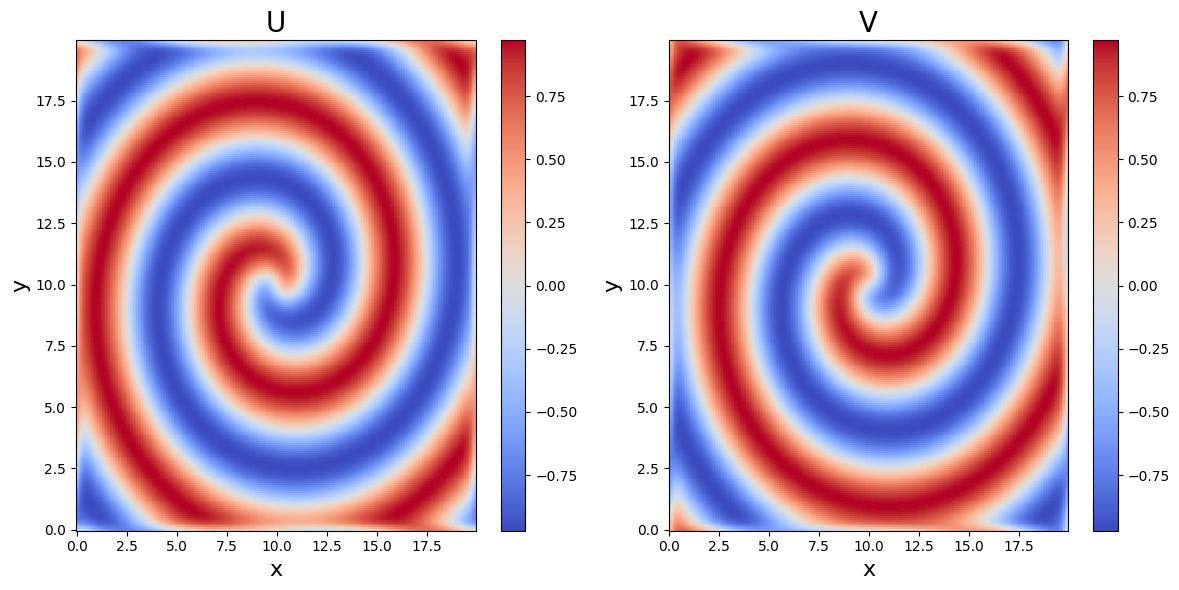

In [56]:
import numpy as np
import matplotlib.pyplot as plt

n = len(x)  # also the length of y

# Create the meshgrid
xx, yy = np.meshgrid(
    np.arange(n) * dx,
    np.arange(n) * dy
)

# Function to create subplots
def create_subplot(ax, data, title_text):
    c = ax.pcolor(xx, yy, data, cmap='coolwarm')
    ax.set_title(title_text, fontsize=20)
    ax.set_xlabel('x', fontsize=16)
    ax.set_ylabel('y', fontsize=16)
    plt.colorbar(c, ax=ax)

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot U
create_subplot(axs[0], U[:, :, 10], 'U')

# Plot V
create_subplot(axs[1], V[:, :, 10], 'V')

plt.tight_layout()
plt.show()


Also in this case, the values are the same of the tutorial. The values weren't possible to be seen directly using the database as it wasn't present in the example. Even running it on Matlab was too computationally expensive. But we have validated our hypothesis with plotting

### Without added noise

In [58]:
np.random.seed(0) # so that numbers in paper are reproducible

num_xy = 5000 # needs to be very high to work with noise
num_t = 30
num_points = num_xy * num_t
boundary = 5
points = {}
count = 0

for p in range(num_xy):
    x = np.random.choice(np.arange(boundary,n-boundary),1)[0]
    y = np.random.choice(np.arange(boundary,n-boundary),1)[0]
    for t in range(num_t):
        points[count] = [x,y,6*t+10]
        count = count + 1

In [59]:
# Take up to second order derivatives.
u = np.zeros((num_points,1))
v = np.zeros((num_points,1))
ut = np.zeros((num_points,1))
vt = np.zeros((num_points,1))
ux = np.zeros((num_points,1))
uy = np.zeros((num_points,1))
uxx = np.zeros((num_points,1))
uxy = np.zeros((num_points,1))
uyy = np.zeros((num_points,1))
vx = np.zeros((num_points,1))
vy = np.zeros((num_points,1))
vxx = np.zeros((num_points,1))
vxy = np.zeros((num_points,1))
vyy = np.zeros((num_points,1))

N = 2*boundary-1  # number of points to use in fitting
Nt = N
deg = 4 # degree of polynomial to use

for p in points.keys():

    [x,y,t] = points[p]

    # value of function
    u[p] = U[x,y,t]
    v[p] = V[x,y,t]

    # time derivatives
    ut[p] = PolyDiffPoint(U[x,y,t-(Nt-1)//2:t+(Nt+1)//2], np.arange(Nt)*dt, deg, 1)[0]
    vt[p] = PolyDiffPoint(V[x,y,t-(Nt-1)//2:t+(Nt+1)//2], np.arange(Nt)*dt, deg, 1)[0]

    # spatial derivatives
    ux_diff = PolyDiffPoint(U[x-(N-1)//2:x+(N+1)//2,y,t], np.arange(N)*dx, deg, 2)
    uy_diff = PolyDiffPoint(U[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    vx_diff = PolyDiffPoint(V[x-(N-1)//2:x+(N+1)//2,y,t], np.arange(N)*dx, deg, 2)
    vy_diff = PolyDiffPoint(V[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    ux_diff_yp = PolyDiffPoint(U[x-(N-1)//2:x+(N+1)//2,y+1,t], np.arange(N)*dx, deg, 2)
    ux_diff_ym = PolyDiffPoint(U[x-(N-1)//2:x+(N+1)//2,y-1,t], np.arange(N)*dx, deg, 2)
    vx_diff_yp = PolyDiffPoint(V[x-(N-1)//2:x+(N+1)//2,y+1,t], np.arange(N)*dx, deg, 2)
    vx_diff_ym = PolyDiffPoint(V[x-(N-1)//2:x+(N+1)//2,y-1,t], np.arange(N)*dx, deg, 2)

    ux[p] = ux_diff[0]
    uy[p] = uy_diff[0]
    uxx[p] = ux_diff[1]
    uxy[p] = (ux_diff_yp[0]-ux_diff_ym[0])/(2*dy)
    uyy[p] = uy_diff[1]

    vx[p] = vx_diff[0]
    vy[p] = vy_diff[0]
    vxx[p] = vx_diff[1]
    vxy[p] = (vx_diff_yp[0]-vx_diff_ym[0])/(2*dy)
    vyy[p] = vy_diff[1]

In [60]:
# Form Theta using up to quadratic polynomials in all variables.
X_data = np.hstack([u,v])
X_ders = np.hstack([np.ones((num_points,1)), ux, uy, uxx, uxy, uyy, vx, vy, vxx, vxy, vyy])
X_ders_descr = ['','u_{x}', 'u_{y}','u_{xx}','u_{xy}','u_{yy}','v_{x}', 'v_{y}','v_{xx}','v_{xy}','v_{yy}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 3, data_description = ['u','v'])
['1'] + description[1:]

['1',
 'u_{x}',
 'u_{y}',
 'u_{xx}',
 'u_{xy}',
 'u_{yy}',
 'v_{x}',
 'v_{y}',
 'v_{xx}',
 'v_{xy}',
 'v_{yy}',
 'v',
 'u',
 'v^2',
 'uv',
 'u^2',
 'v^3',
 'uv^2',
 'u^2v',
 'u^3',
 'vu_{x}',
 'uu_{x}',
 'v^2u_{x}',
 'uvu_{x}',
 'u^2u_{x}',
 'v^3u_{x}',
 'uv^2u_{x}',
 'u^2vu_{x}',
 'u^3u_{x}',
 'vu_{y}',
 'uu_{y}',
 'v^2u_{y}',
 'uvu_{y}',
 'u^2u_{y}',
 'v^3u_{y}',
 'uv^2u_{y}',
 'u^2vu_{y}',
 'u^3u_{y}',
 'vu_{xx}',
 'uu_{xx}',
 'v^2u_{xx}',
 'uvu_{xx}',
 'u^2u_{xx}',
 'v^3u_{xx}',
 'uv^2u_{xx}',
 'u^2vu_{xx}',
 'u^3u_{xx}',
 'vu_{xy}',
 'uu_{xy}',
 'v^2u_{xy}',
 'uvu_{xy}',
 'u^2u_{xy}',
 'v^3u_{xy}',
 'uv^2u_{xy}',
 'u^2vu_{xy}',
 'u^3u_{xy}',
 'vu_{yy}',
 'uu_{yy}',
 'v^2u_{yy}',
 'uvu_{yy}',
 'u^2u_{yy}',
 'v^3u_{yy}',
 'uv^2u_{yy}',
 'u^2vu_{yy}',
 'u^3u_{yy}',
 'vv_{x}',
 'uv_{x}',
 'v^2v_{x}',
 'uvv_{x}',
 'u^2v_{x}',
 'v^3v_{x}',
 'uv^2v_{x}',
 'u^2vv_{x}',
 'u^3v_{x}',
 'vv_{y}',
 'uv_{y}',
 'v^2v_{y}',
 'uvv_{y}',
 'u^2v_{y}',
 'v^3v_{y}',
 'uv^2v_{y}',
 'u^2vv_{y}',
 'u^3v_

In [61]:
c = TrainSTRidge(X,ut,10**-5,1)
print_pde(c, description)

u_t = (0.099972 +0.000000i)u_{xx}
    + (0.100004 +0.000000i)u_{yy}
    + (0.999913 +0.000000i)u
    + (0.999979 +0.000000i)v^3
    + (-0.999882 +0.000000i)uv^2
    + (0.999977 +0.000000i)u^2v
    + (-0.999900 +0.000000i)u^3
   


In [62]:
c = TrainSTRidge(X,vt,10**-5,1)
print_pde(c, description, ut = 'v_t')

v_t = (0.100032 +0.000000i)v_{xx}
    + (0.099968 +0.000000i)v_{yy}
    + (1.000278 +0.000000i)v
    + (-1.000293 +0.000000i)v^3
    + (-0.999971 +0.000000i)uv^2
    + (-1.000268 +0.000000i)u^2v
    + (-0.999978 +0.000000i)u^3
   


In [63]:
err = abs(np.array([(0.1-0.099972)*100/0.1,  (0.1-0.100032)*100/0.1,
                    (0.1-0.100004)*100/0.1,  (0.1-0.099968)*100/0.1,
                    (1-0.999913)*100,        (1-1.000278)*100,
                    (1-0.999979)*100,        (1-1.000293)*100,
                    (1-0.999882)*100,        (1-0.999971)*100,
                    (1-0.999977)*100,        (1-1.000268)*100,
                    (1-0.999900)*100,        (1-0.999978)*100]))
print(np.mean(err))
print(np.std(err))

0.01570714285714092
0.012193233737594874


### With added noise

In [64]:
# Now try adding noise.
np.random.seed(0)

Un = U + 0.005*np.std(U)*np.random.randn(n,n,steps)
Vn = V + 0.005*np.std(V)*np.random.randn(n,n,steps)

In [65]:
# Denoise using POD.
FUn = Un.reshape(n**2,steps)
FVn = Vn.reshape(n**2,steps)

In [66]:
uun,usn,uvn = np.linalg.svd(FUn, full_matrices = False)
vun,vsn,vvn = np.linalg.svd(FVn, full_matrices = False)

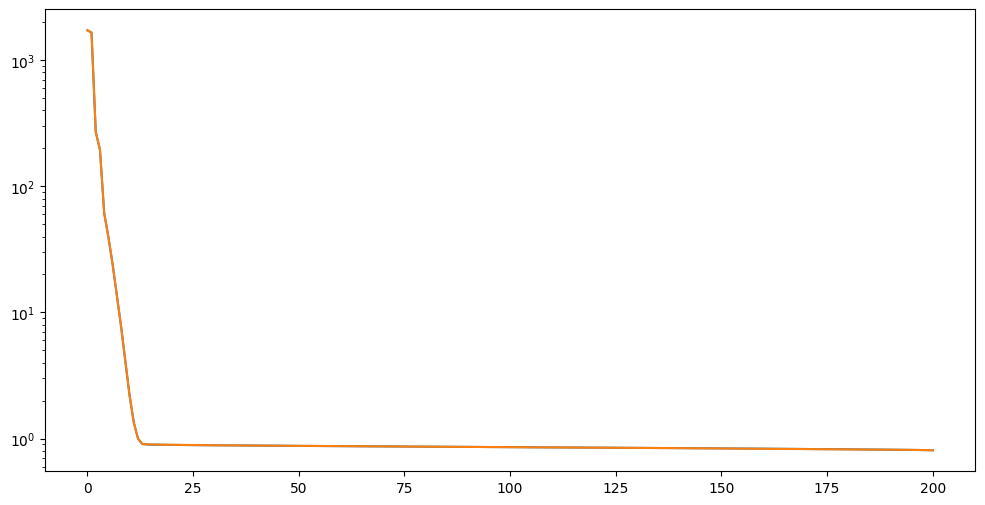

In [68]:
from matplotlib.pyplot import semilogy

semilogy(usn)
semilogy(vsn)

In [69]:
dim = 15
Un = (uun[:,:dim].dot(np.diag(usn[:dim]).dot(uvn[:dim,:]))).reshape(n,n,steps)
Vn = (vun[:,:dim].dot(np.diag(vsn[:dim]).dot(vvn[:dim,:]))).reshape(n,n,steps)

In [70]:
# Take up to second order derivatives.
un = np.zeros((num_points,1))
vn = np.zeros((num_points,1))
utn = np.zeros((num_points,1))
vtn = np.zeros((num_points,1))
uxn = np.zeros((num_points,1))
uyn = np.zeros((num_points,1))
uxxn = np.zeros((num_points,1))
uxyn = np.zeros((num_points,1))
uyyn = np.zeros((num_points,1))
vxn = np.zeros((num_points,1))
vyn = np.zeros((num_points,1))
vxxn = np.zeros((num_points,1))
vxyn = np.zeros((num_points,1))
vyyn = np.zeros((num_points,1))

N = 2*boundary-1  # number of points to use in fitting polynomial for spatial derivative
Nt = N # and for time derivatives
deg = 4 # degree of polynomial to use

for p in points.keys():

    [x,y,t] = points[p]

    # value of function
    un[p] = Un[x,y,t]
    vn[p] = Vn[x,y,t]

    # time derivatives
    utn[p] = PolyDiffPoint(Un[x,y,t-(Nt-1)//2:t+(Nt+1)//2], np.arange(Nt)*dt, deg, 1)[0]
    vtn[p] = PolyDiffPoint(Vn[x,y,t-(Nt-1)//2:t+(Nt+1)//2], np.arange(Nt)*dt, deg, 1)[0]

    # spatial derivatives
    ux_diff_n = PolyDiffPoint(Un[x-(N-1)//2:x+(N+1)//2,y,t], np.arange(N)*dx, deg, 2)
    uy_diff_n = PolyDiffPoint(Un[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    vx_diff_n = PolyDiffPoint(Vn[x-(N-1)//2:x+(N+1)//2,y,t], np.arange(N)*dx, deg, 2)
    vy_diff_n = PolyDiffPoint(Vn[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    ux_diff_yp_n = PolyDiffPoint(Un[x-(N-1)//2:x+(N+1)//2,y+1,t], np.arange(N)*dx, deg, 2)
    ux_diff_ym_n = PolyDiffPoint(Un[x-(N-1)//2:x+(N+1)//2,y-1,t], np.arange(N)*dx, deg, 2)
    vx_diff_yp_n = PolyDiffPoint(Vn[x-(N-1)//2:x+(N+1)//2,y+1,t], np.arange(N)*dx, deg, 2)
    vx_diff_ym_n = PolyDiffPoint(Vn[x-(N-1)//2:x+(N+1)//2,y-1,t], np.arange(N)*dx, deg, 2)

    uxn[p] = ux_diff_n[0]
    uyn[p] = uy_diff_n[0]
    uxxn[p] = ux_diff_n[1]
    uxyn[p] = (ux_diff_yp_n[0]-ux_diff_ym_n[0])/(2*dy)
    uyyn[p] = uy_diff_n[1]

    vxn[p] = vx_diff_n[0]
    vyn[p] = vy_diff_n[0]
    vxxn[p] = vx_diff_n[1]
    vxyn[p] = (vx_diff_yp_n[0]-vx_diff_ym_n[0])/(2*dy)
    vyyn[p] = vy_diff_n[1]

In [71]:
# Form Theta using up to quadratic polynomials in all variables.
X_data_n = np.hstack([un,vn])
X_ders_n = np.hstack([np.ones((num_points,1)), uxn, uyn, uxxn, uxyn, uyyn, vxn, vyn, vxxn, vxyn, vyyn])
X_ders_descr = ['','u_{x}', 'u_{y}','u_{xx}','u_{xy}','u_{yy}','v_{x}', 'v_{y}','v_{xx}','v_{xy}','v_{yy}']
X_n, description = build_Theta(X_data_n, X_ders_n, X_ders_descr, 3, data_description = ['u','v'])

In [72]:
lam = 10**-5
d_tol = 1
c = TrainSTRidge(X_n,utn,lam,d_tol)
print_pde(c, description)

u_t = (0.094923 +0.000000i)u_{xx}
    + (0.095022 +0.000000i)u_{yy}
    + (0.945835 +0.000000i)u
    + (0.999732 +0.000000i)v^3
    + (-0.945751 +0.000000i)uv^2
    + (0.999784 +0.000000i)u^2v
    + (-0.945507 +0.000000i)u^3
   


In [73]:
lam = 10**-5
d_tol = 1
c = TrainSTRidge(X_n,vtn,lam,d_tol)
print_pde(c, description, ut = 'v_t')

v_t = (0.094980 +0.000000i)v_{xx}
    + (0.094898 +0.000000i)v_{yy}
    + (0.946891 +0.000000i)v
    + (-0.946863 +0.000000i)v^3
    + (-0.999398 +0.000000i)uv^2
    + (-0.946404 +0.000000i)u^2v
    + (-0.999661 +0.000000i)u^3
   


In [74]:
err = abs(np.array([(0.1-0.094923)*100/0.1,  (0.1-0.094980)*100/0.1,
                    (0.1-0.095022)*100/0.1,  (0.1-0.094898)*100/0.1,
                    (1-0.945835)*100,        (1-0.946891)*100,
                    (1-0.999732)*100,        (1-0.946863)*100,
                    (1-0.945751)*100,        (1-0.999398)*100,
                    (1-0.999784)*100,        (1-0.946404)*100,
                    (1-0.945507)*100,        (1-0.999661)*100]))
print(np.mean(err))
print(np.std(err))

3.7567428571428603
2.3579470479678744


### Comment on the exercise

In this case, we have seen the use of a Reaction Diffusion equation. Given the higher dimensions, there was the need of subsampling the data. The results were quite similar to the ones without noise.

## 6 Conclusion and final considerations

In this case we have seen 3 examples of PDE-FIND. The first one was the Burger's equation, the second one was the KdV equation, and the third one was the Reaction Diffusion equation. The results were quite similar to the ones in the tutorial. The error was higher when noise was considered. This is expected as the noise may increase the error in the system.
There are several considerations to be taken into account:
- the visualisation of the data helped to identify the type of equations that we were taking into account
- exploiting a predetermined knowledge would have been helpful to identify the equations. For example, when considering the KdV equation, the algorithm could have improved by considering the two results independently. However, in our case, dividing the two components would have been possible through a certain threshold based on the coordinates. But this would have been a more complex solution.  In general some components to keep in mind are: unit measure, translational symmetry and multiplicative separability.
- the noise was added to the system to see how the algorithm would behave. The results were quite similar to the ones without noise. This is a good sign as the algorithm is robust to noise.

## 7 Linear Solvers

In the final delivery of the project, it's written to "use an existing sparse linear system solver, or write your
own solver to solve". For this purpose, one possibility is to write the solvers for each of the equations to have a data comparison and understand if the results are similar.
Here there is the implementation of the solvers for the three equations.

In [ ]:
import numpy as np

def normalize_features(X, norm_order):
    """
    Normalize the features of the matrix X using the specified norm order.

    Parameters:
    X (np.ndarray): The input feature matrix.
    norm_order (int): The order of the norm used for normalization.

    Returns:
    np.ndarray, np.ndarray: The normalized feature matrix and the normalization factors.
    """
    normalization_factors = 1.0 / np.linalg.norm(X, axis=0, ord=norm_order)
    X_normalized = X * normalization_factors
    return X_normalized, normalization_factors

def ridge_regression(X, y, lambda_reg):
    """
    Perform ridge regression to find the coefficients.

    Parameters:
    X (np.ndarray): The input feature matrix.
    y (np.ndarray): The target vector.
    lambda_reg (float): Regularization parameter for ridge regression.

    Returns:
    np.ndarray: The regression coefficients.
    """
    if lambda_reg != 0:
        return np.linalg.lstsq(X.T @ X + lambda_reg * np.eye(X.shape[1]), X.T @ y, rcond=None)[0]
    else:
        return np.linalg.lstsq(X, y, rcond=None)[0]

def threshold_coefficients(w, tolerance):
    """
    Identify significant and insignificant coefficient indices based on the tolerance.

    Parameters:
    w (np.ndarray): The regression coefficients.
    tolerance (float): The threshold for significance.

    Returns:
    np.ndarray, np.ndarray: The indices of significant and insignificant coefficients.
    """
    significant_indices = np.where(np.abs(w) > tolerance)[0]
    insignificant_indices = np.where(np.abs(w) < tolerance)[0]
    return significant_indices, insignificant_indices

def update_coefficients(X, y, w, significant_indices, lambda_reg):
    """
    Update the coefficients by performing ridge regression on the significant indices.

    Parameters:
    X (np.ndarray): The input feature matrix.
    y (np.ndarray): The target vector.
    w (np.ndarray): The current regression coefficients.
    significant_indices (np.ndarray): The indices of significant coefficients.
    lambda_reg (float): Regularization parameter for ridge regression.

    Returns:
    np.ndarray: The updated regression coefficients.
    """
    w[significant_indices] = ridge_regression(X[:, significant_indices], y, lambda_reg)
    return w

def sequential_threshold_ridge_regression(X0, y, lambda_reg, max_iterations, tolerance, norm_order=2, verbose=False):
    """
    Perform Sequential Threshold Ridge Regression (STRidge) to achieve a sparse solution.

    This method attempts to find a sparse set of coefficients for the regression problem
    by iteratively applying ridge regression and thresholding small coefficients.

    Parameters:
    X0 (np.ndarray): The input feature matrix.
    y (np.ndarray): The target vector.
    lambda_reg (float): Regularization parameter for ridge regression.
    max_iterations (int): Maximum number of iterations to run the algorithm.
    tolerance (float): Threshold below which coefficients are set to zero.
    norm_order (int, optional): The order of the norm used for normalization. Default is 2.
    verbose (bool, optional): If True, print intermediate results.

    Returns:
    np.ndarray: The resulting coefficients vector.
    """
    if norm_order != 0:
        X_normalized, normalization_factors = normalize_features(X0, norm_order)
    else:
        X_normalized, normalization_factors = X0, None

    w = ridge_regression(X_normalized, y, lambda_reg)
    relevant_features = X0.shape[1]
    significant_indices, insignificant_indices = threshold_coefficients(w, tolerance)

    for iteration in range(max_iterations):
        new_significant_indices = np.setdiff1d(np.arange(X0.shape[1]), insignificant_indices)

        if relevant_features == len(new_significant_indices):
            break
        relevant_features = len(new_significant_indices)

        if len(new_significant_indices) == 0:
            if iteration == 0 and verbose:
                print("Tolerance too high - all coefficients are below the threshold.")
            return w

        significant_indices = new_significant_indices
        w[insignificant_indices] = 0
        w = update_coefficients(X_normalized, y, w, significant_indices, lambda_reg)
        significant_indices, insignificant_indices = threshold_coefficients(w, tolerance)

    if len(significant_indices) > 0:
        w[significant_indices] = ridge_regression(X_normalized[:, significant_indices], y, lambda_reg)

    if normalization_factors is not None:
        return normalization_factors * w
    return w


In any way, the work is a variation of what has been done in the paper, alredy.
If we may want to build the code from scratch, it could have also been possible still using a function building derivatives, theta and train and obtain STRidge. The results would have hopefully been similar.
Moreover, when calculating the equations it may be possible to employ some already defined equation or constant multiplier to make the calculation potentially more accurate.